In [1]:
from PIL import Image

from tensorflow import keras, convert_to_tensor

from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import array_to_img

from keras import layers

import numpy as np
import tensorflow as tf

2021-10-28 23:04:27.448938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


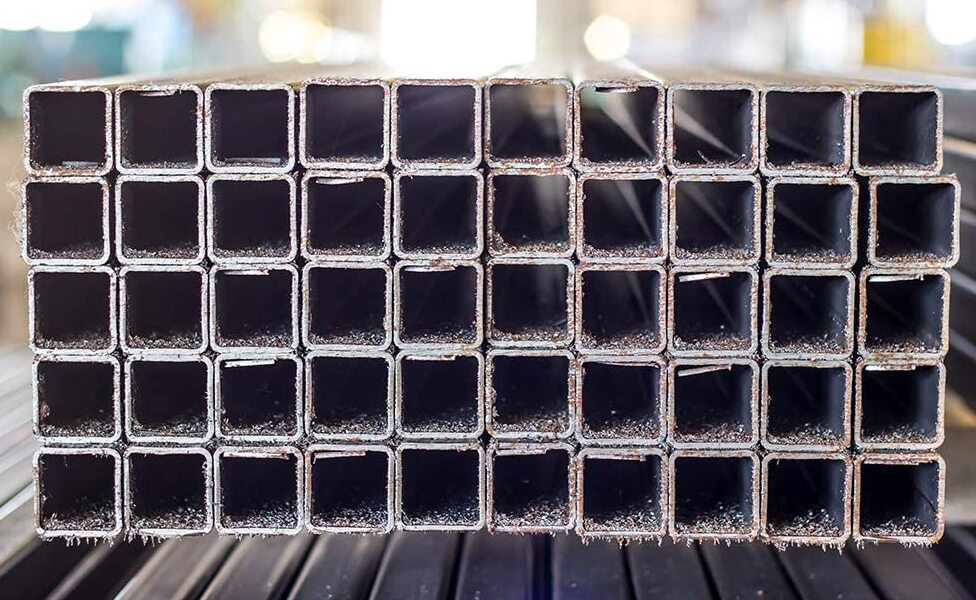

In [2]:
# Load the image

image = load_img('./data/pipes.jpeg')

numpy_data = img_to_array(image)
data = convert_to_tensor(numpy_data) / 255.0

image

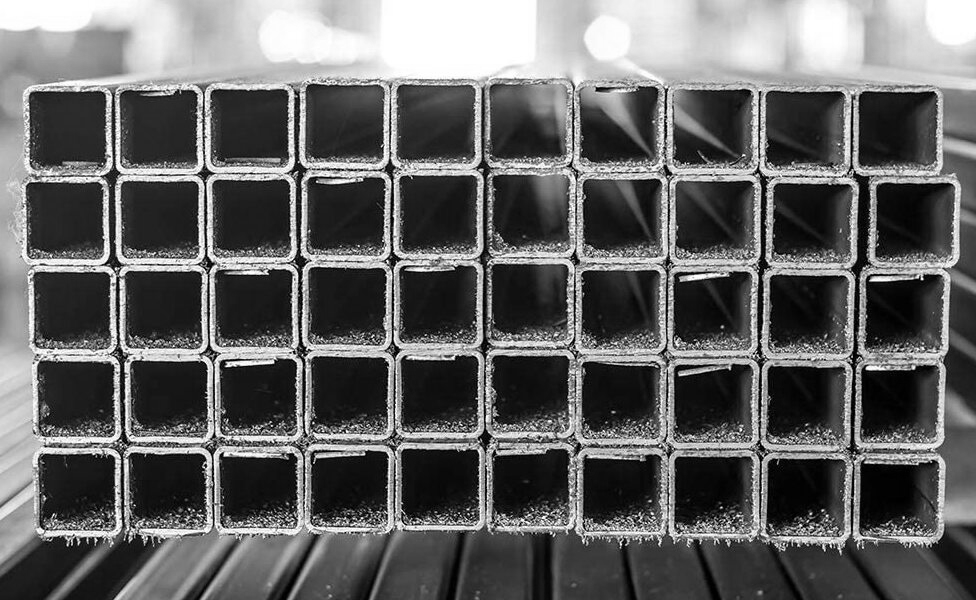

In [3]:
# Grayscale

def rgb_kernel(r, g, b):
    def init_kernel(shape, dtype=tf.float32):
        # shape = (height x width) x in_channels x out_channels
        red = np.array([[r]])
        green = np.array([[g]])
        blue = np.array([[b]])

        kernel_in = np.array([[red, green, blue]])
        kernel_in = np.transpose(kernel_in, (2, 3, 1, 0))

        return tf.constant(kernel_in, dtype=dtype)

    return init_kernel

def to_grayscale(rgb_image, r, g, b):
    layer = layers.Conv2D(
        1, (1, 1),
        strides=1,
        kernel_initializer=rgb_kernel(r, g, b),
        padding = 'same',
        input_shape = rgb_image.shape,
        trainable=False,
    )

    return layer(tf.reshape(rgb_image, shape=[1, *rgb_image.shape]))

def output_to_img(out):
    grayscale = np.transpose(out.numpy(), (0, 3, 1, 2))[0, 0]
    return Image.fromarray(np.uint8(grayscale * 255), 'L')


grayscale = to_grayscale(data, r=.299, g=.587, b=.114)
output_to_img(grayscale)

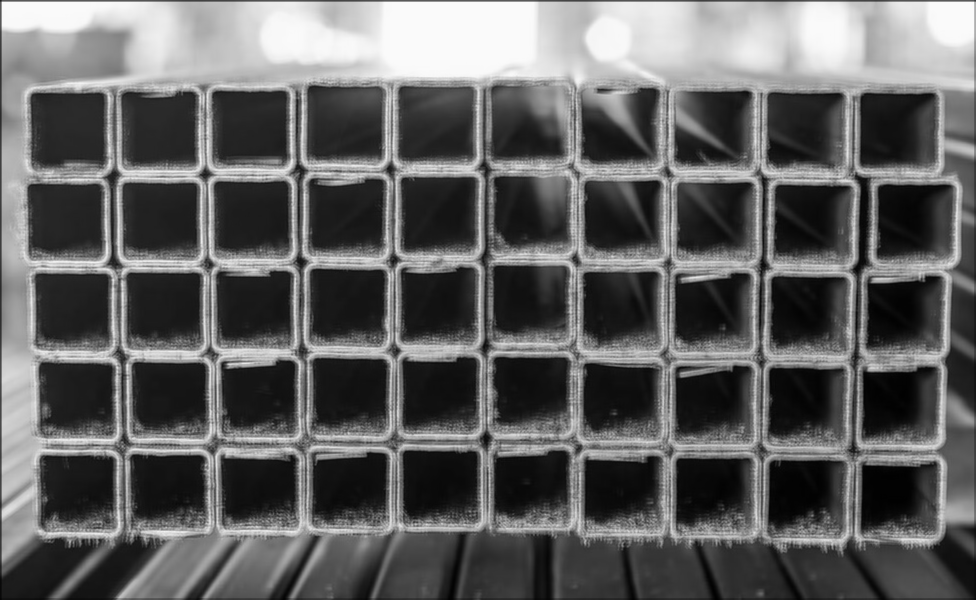

In [4]:
# Blur

def gaussian_kernel(n, std=1):
    def init_kernel(shape, dtype=tf.float32):
        # shape = (height x width) x in_channels x out_channels
        G = np.zeros((n, n))

        std_2 = std ** 2
        const = 1 / (2 * np.pi * std_2)

        y_center = n // 2
        x_center = n // 2
        for y in range(n):
            dy = y - y_center
            for x in range(n):
                dx = x - x_center

                G[dy][dx] = const * np.exp(-(dx ** 2 + dy ** 2) / (2 * std_2))

        kernel_in = np.array([[G]])
        kernel_in = np.transpose(kernel_in, (2, 3, 1, 0))

        return tf.constant(kernel_in, dtype=dtype)

    return init_kernel

def gaussian_blur(grayscale, n):
    layer = layers.Conv2D(
        1, (n, n),
        strides=1,
        kernel_initializer=gaussian_kernel(n),
        padding = 'same',
        trainable=False,
    )

    return layer(grayscale)

blurred = gaussian_blur(grayscale, 5)
output_to_img(blurred)

In [6]:
# Blur

def sobel_kernel():
    def init_kernel(shape, dtype=tf.float32):
        # shape = (height x width) x in_channels x out_channels
        sobel_x = np.array([
            [1, 0, -1],
            [2, 0, -2],
            [1, 0, -1]
        ])

        sobel_y = np.array([
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1],
        ])

        kernel_in = np.array([[sobel_x, sobel_y]])
        kernel_in = np.transpose(kernel_in, (2, 3, 0, 1))

        return tf.constant(kernel_in, dtype=dtype)

    return init_kernel

def gaussian_blur(blurred):
    layer = layers.Conv2D(
        2, (3, 3),
        strides=1,
        kernel_initializer=sobel_kernel(),
        padding = 'same',
        trainable=False,
    )

    return layer(blurred)

def show_gradients(out):
    grayscale = np.transpose(out.numpy(), (0, 3, 1, 2))[0]
    gradient_x = grayscale[0]
    gradient_y = grayscale[1]

    return Image.fromarray(np.uint8(gradient_x * 255), 'L'), Image.fromarray(np.uint8(gradient_y * 255), 'L')

gradients = gaussian_blur(blurred)
gradient_x_img, gradient_y_img = show_gradients(gradients)

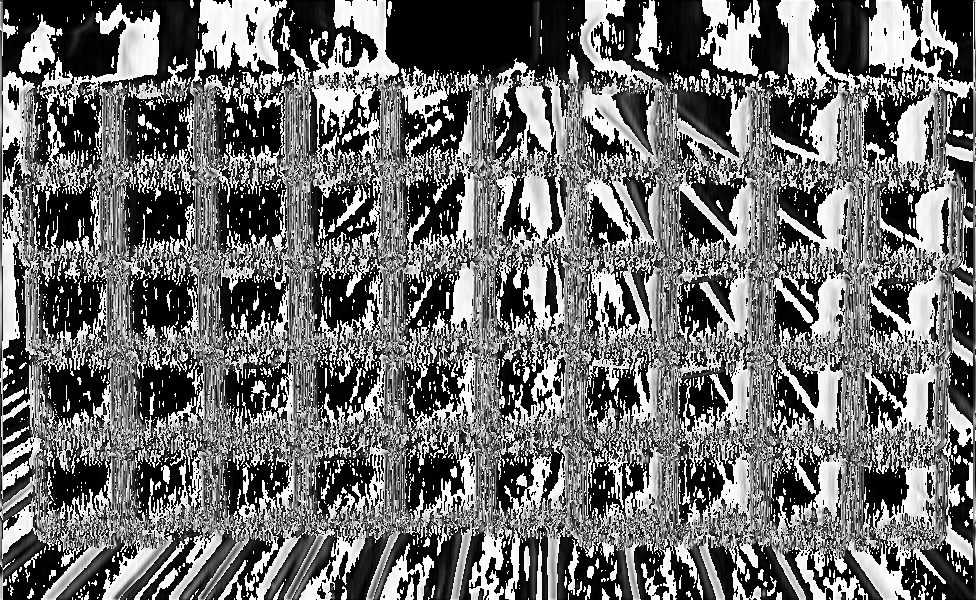

In [7]:
gradient_x_img

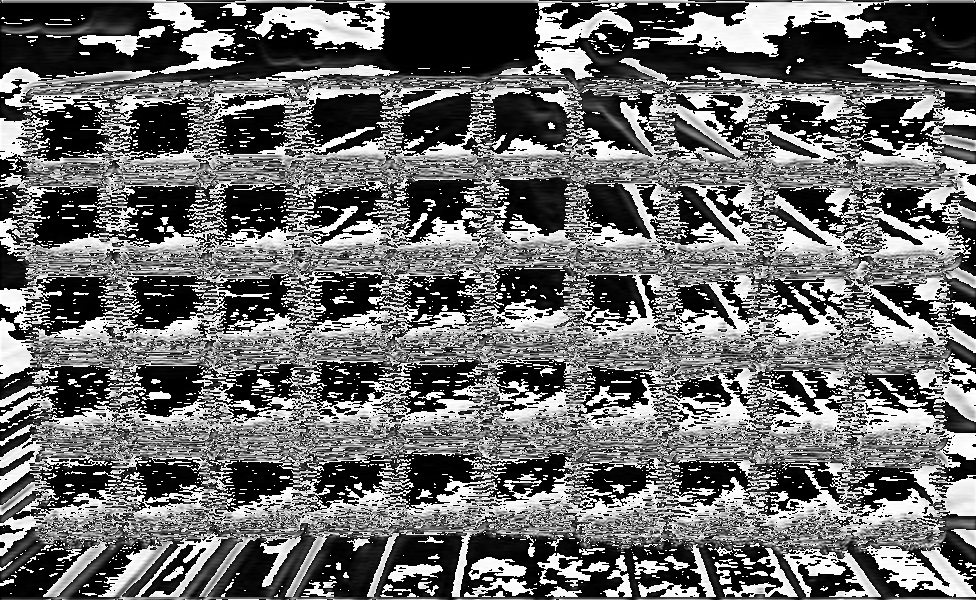

In [8]:
gradient_y_img

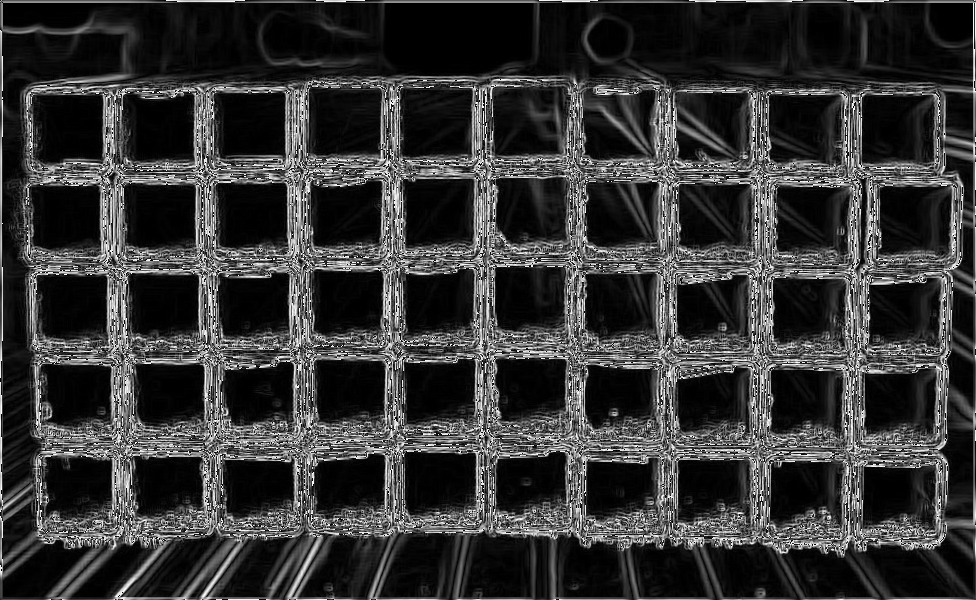

In [9]:
# Square, sum and sqrt

def compute_gradient_intensity(gradients):
    gradients = tf.transpose(gradients, (0, 3, 1, 2))[0]
    squared = tf.pow(gradients, 2)
    gradients_x, gradients_y = squared[0], squared[1]
    summed = gradients_x + gradients_y
    return tf.sqrt(summed)


def show_gradient_intensity(intensity):
    return Image.fromarray(np.uint8(intensity * 255), 'L')

gradient_intensity = compute_gradient_intensity(gradients)
show_gradient_intensity(gradient_intensity)

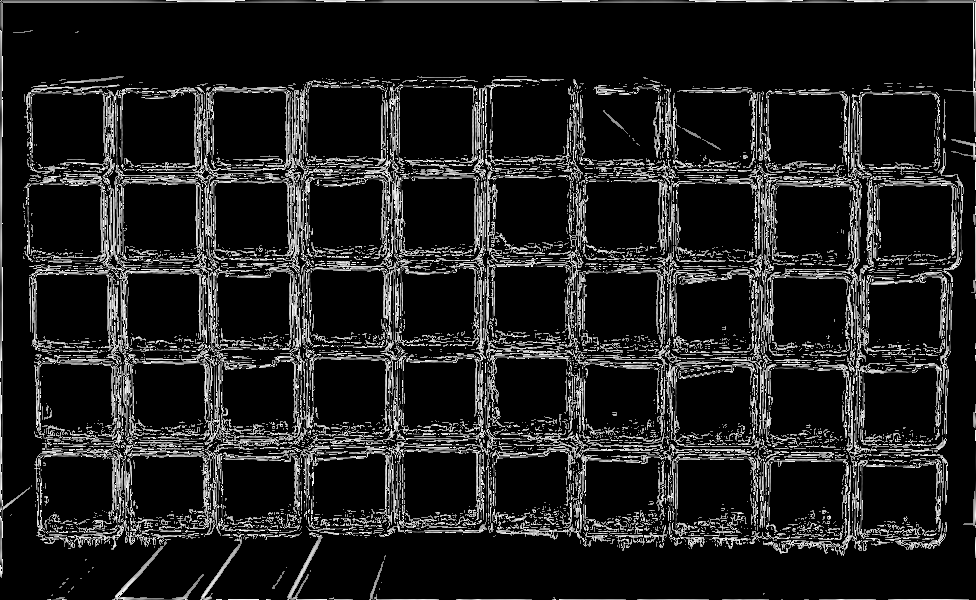

In [11]:
## applying threshold to gradient

threshold = .5
layer = keras.layers.ReLU(threshold=threshold)

gradient_after_relu = layer(gradient_intensity)
show_gradient_intensity(gradient_after_relu)

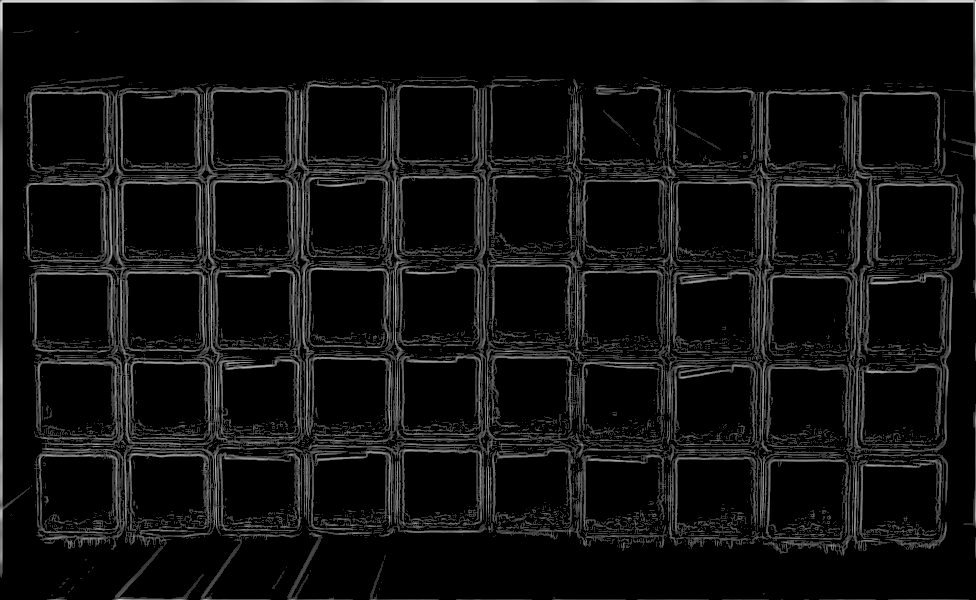

In [15]:
## normalizing gradient

normalized_gradient = gradient_after_relu / tf.math.reduce_max(gradient_after_relu)
show_gradient_intensity(normalized_gradient)

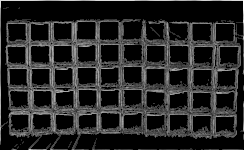

In [83]:
## pooling
max_pool_2d = keras.layers.MaxPooling2D(pool_size=(4, 4),
                                           strides=(4, 4), padding='same')
# 600 x 976
# normalized_gradient.shape
def show_pool_2d(out):
    out = np.transpose(out.numpy(), (0, 3, 1, 2))[0, 0]
    return Image.fromarray(np.uint8(out * 255), 'L')

x = tf.reshape(normalized_gradient, shape=[1, *normalized_gradient.shape, 1])
y = max_pool_2d(x)

show_pool_2d(y)

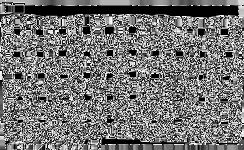

In [85]:
def square_kernel(n):
    # shape = (height x width) x in_channels x out_channels
    def make_kernel(shape, dtype=tf.float32):
        square = np.zeros((n, n))
        for i in range(n):
            square[i, 0] = 1.0
            square[i, n - 1] = 1.0
            square[0, i] = 1.0
            square[n - 1, i] = 1.0

        kernel_in = np.array([[square]])
        kernel_in = np.transpose(kernel_in, (2, 3, 1, 0))

        return tf.constant(kernel_in, dtype=dtype)

    return make_kernel

def square_conv2d_layers(sizes):
    for n in sizes:
        layer = keras.layers.Conv2DTranspose(1, (n, n), padding='same', kernel_initializer=square_kernel(n))
        yield layer

def apply_conv2d_layers(y, sizes):
    layers = square_conv2d_layers(square_sizes)
    return [layer(y) for layer in layers]

def show(out):
    grayscale = np.transpose(out.numpy(), (0, 3, 1, 2))[0, 0]
    return Image.fromarray(np.uint8(grayscale * 255), 'L')

from_n = 3
to_n = 15
square_sizes = range(from_n, to_n + 1)

foo = apply_conv2d_layers(y, square_sizes)
show(foo[8])

In [66]:
def apply_threshold(values, threshold = .3):
    threshold_layer = keras.layers.ReLU(threshold=threshold)
    return [threshold_layer(v) for v in values]

def norm(values):
    return [v / tf.reduce_max(v) for v in values]

def apply_conv2d(ys, sizes):
    layers = square_conv2d_layers(sizes)
    return [ layer(y) for y, layer in zip(ys, layers)]


y1 = norm(foo)
y2 = apply_threshold(y1)
y3 = apply_conv2d(y2, square_sizes)

(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)
(1, 150, 244, 1)


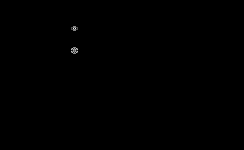

In [69]:
for v in y3:
    # 1 x 150 x 244 x 1
    print(v.shape)


show(y3[0])

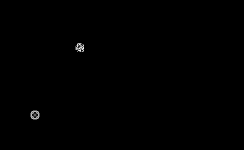

In [70]:
show(y3[1])